# Application of Tfidf-vectorizer on wine data

*This study is the second prelude to a grape variety classifier based on semi-professional wine notes. We present a bag-of-words type analysis of data using term frequencies alone and inverse document frequency correction as well. We examine how applicable are these word vectorizers in order to differentiate between grape varieties.*

Analysing data and concepts is key to create a reliable classifier in machine learning. The style of the text input in our case can vary significantly, therefore it is unlikely that a classifier will do a perfect job. The analysis presented here helps to understand the deficiencies of the model and give us some hints, why was a wine description classified into one grape variety and not to the other. 

In the [first part](https://diveki.github.io/projects/wine/wine.html) of the blind taster analysis we used brute force to collect data, reduce noise and extract term frequency information on the wine descriptions. Also we detailed where had our data come from and what preprocessing had we used to prepare it to analysis. 

In this study we will use *scikit-learn*'s [count vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [tf-idf vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to build a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) vector model and use their methods to derive numerical evidence on the similarity or dissimilarity of the grape varieties. 

In the [final study](https://diveki.github.io/projects/wine/sommelier.html) we incorporate these vectorizers into a classifier that will predict what grape was used to make a wine based on the wine's description.


In the begining of this study we review some **Natural Language Processing** (NLP) techniques and their meaning and then we apply those concept to our wine dataset and try to understand what are the similarities and differencies in the descriptions of the wines made from different grapes. Here we will cover the following topics:

1. [Bag-of-words concept](#ch1)
2. [Reviewing the previous Article (tokenization, filtering, pos tagging, comparing)](#ch2)
3. [Term frequency and the count vectorizer](#ch3)
4. [Inverse document frequency and the Tf-idf vectorizer](#ch4)
5. [Similarity study of documents belonging to one class](#ch5)
6. [Conclusion](#ch6)
7. [References](#ch7)

<a id='ch1'></a>
# 1. Bag-of-words concept

 The bag-of-words concept is a very simple approach to text analysis in NLP. In its basic form it relies on the decomposition of text into words. From the union of all words, let us say N words, from all documents, M documents, under investigetion it forms a vector (refered to as vocabulary). Each document can be represented as a vector of this vocabulary with a length of *N*, resulting in a matrix of size $M\times N$. The figure below shows a detailed demonstration of this concept (taken from [Quora discussion](https://www.quora.com/What-is-the-bag-of-words-algorithm)).

![Bag-of-words](https://qph.fs.quoracdn.net/main-qimg-4934f0958e121d33717f848230ef664a)

The obtained matrix is usually very sparse, since only a small portion of the vocabulary is expected to appear in each document. Often, people apply stopwords. These are usually filling words which are very frequent in all documents, but does not have any descriptive meaning, like *for, is, of the, etc.* When applying the bag-of-word concept we leave out the stopwords from the analysis. The bag-of-words concept does not take into account the order of the words, therefore the causality and references between words are lost. This can be somewhat improved if one introduces N-grams.

The figure above is a special case of N-grams, the 1-gram. The text is decomposed into individual words. In N-grams the text is decomposed into N consecutive term. For example, in the case of the above figure the first two 2-grams could be: *'quick brown', 'brown fox'* (note that we took into account the stopwords).

The bag-of-words concept is usually paired with a document classifier where the decomposed terms are features. There are several types of classifiers but we will discuss the term frequency and term frequency with inverse document frequency methods. 

Before discussing these classifiers we first quickly review the concepts applied in the [previous study](https://diveki.github.io/projects/wine/wine.html).

<a id='ch2'></a>
# 2. Reviewing the previous Article (tokenization, filtering, pos tagging, comparing)

Let us start by importing python modules that we will use in the analysis. 

In [1]:
%matplotlib inline
# packages and methods for data manipulation
import pandas as pd
import numpy as np
from functools import reduce

# packages and methods for text analysis
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

# function to split data into train and test samples
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# packages for visualization
import seaborn as sns
import matplotlib.pyplot as plt


Then we load the data that contains the scraped and pre-cleaned information about the wines. This data and the whole project can be found at my [github repository](https://github.com/diveki/WineSommelier). Feel free to take a copy of it and improve it. The data collection and processing is explained in the [previous study](https://diveki.github.io/projects/wine/wine.html). 

Just as before we are mainly interested in the *grape_variety* and *description* columns however real sommeliers can take a look at the colour of the wine, therefore the *colour* can be a featur too. 

In [2]:
filename = '../DataBase/5_grape_db.xlsx'

a0 = pd.read_excel(filename)
a0.head()

,abv,colour,country,description,grape_variety,name,Body
0,13.5,red,USA,this wine has concentrated depth and purity of...,pinot noir,A to Z Pinot Noir 2014,light
1,13.5,red,Argentina,"a delicate, floral wine with soft cherry and s...",pinot noir,Alamos Seleccion Pinot Noir 2016,medium
2,12.5,red,Italy,"a medium-bodied wine, with aromas and flavours...",pinot noir,Alois Lageder Alto Adige Pinot Noir 2014,medium
3,13.5,white,Italy,very fresh aromas and flavours of gooseberry a...,sauvignon blanc,Alois Lageder Terlaner Sauvignon Blanc 2016,medium
4,13.5,red,Argentina,this wine has concentrated aromas and flavours...,cabernet sauvignon,Argento Cabernet Sauvignon 2014,full


In our analysis we will constrain filter out all the grape varieties that occurs less than a predifined *limit* in our dataset.

In [3]:
result = a0['grape_variety']
limit = 40
## removing varieties that have only one member in the database
counts = nltk.Counter(result)
varieties = [key for key in counts if counts[key] > limit]
data_input = a0[a0['grape_variety'].isin(varieties)].reset_index()

We divide our dataset into train and test sets. 67% of the input will belong to the train and the rest to the test. 

In [4]:
# split the data into train and test
combined_features = ['description', 'grape_variety']
target = 'grape_variety'

X_train, X_test, y_train, y_test = train_test_split(data_input[combined_features], data_input[target], 
                                                    test_size=0.33, random_state=42)


The grape varieties in the train set are not equally represented. The white wines, the *chardonnay* and the *sauvignon blanc* have the most samples. Simply because of that feature we can already expect that some words will be more frequent in the white wine descriptions than in the red ones. 

Next we aggregate the wine descriptions by the grape variety. Therefore, we will have four documents (one for each grape) with long descriptions. 

In [5]:
# aggregate description by grape type
grouped = X_train[['grape_variety', 'description']].groupby(['grape_variety']).agg(
    {'description': lambda z: reduce(lambda x,y: ''.join(x+y), z)}
)
grouped.head()

,description
grape_variety,
chardonnay,' quest to create an australian rival to the t...
pinot noir,as seen on tv.the belen estate in chile 's cas...
sauvignon blanc,"this classic displays elements of gooseberry ,..."
syrah,are dedicated to showcasing the wide range of ...


Using this dataset, in the [previous study](https://diveki.github.io/projects/wine/wine.html) we applied the bag-of-words concept by aggregating the wine descriptions by grape varieties. We used the *nltk* package's *word_tokenize* method to obtain 1-gram terms. For each 1-gram we calculated their frequency within each grape variety. 

By visually inspecting these terms and the corresponding frequencies we saw that there are many useless filling words in the text, so we built up a filter, *stop_words*, that removed these terms. 

We have also observed that many of the terms appear in different forms, like in singular and plural form, while actually they should be counted together. *Lemmatization* is the process that brings the words into their common form. A lemmatizer to perform its job needs to know what type of word is it given as an input, a noun, verb, adjective etc. That is determined by the position tagger. We have applied position tagging and lemmatization to find the common form of the words, reducing the vocabulary and possible tightening the number of useful words in the documents. 

Finally, we compared the obtained vocabularies of grape varieties and search for the differences and similarities. We wanted to find out are there words that are characteristic for a certain grape type and appear more frequently for them. For that we calculated correlations and tried to explained the outcome. 

In the following sections we will basically repeat the same thing as in that study, but we will use classifiers like the *CountVectorizer* and *TfidfVectorizer*, to create vocabulary, count words and filter noise. These objects are highly adjustable and easy to use them in a supervised machine learning task. They can be trained to classify a text into a target class and they can predict in which class a new text would belong. This classification and prediction step will be done in the [following study](https://diveki.github.io/projects/wine/sommelier.html). 

Here we will use these classifiers to understand if there are differences or characteristic features between the grape descriptions. 

<a id='ch3'></a>
# 3. Term frequency and the count vectorizer

A simple and easy way to classify documents into topics is to decompose them into words and count their frequency of occurence. This number is basically the raw count form of term frequency. One assumes that if a word is more frequent in a topic than in another then that word is probably characteristic to that topic. There are other forms of term frequency depending on what weighing has been applied [[1](#ch7)], like: boolean, logaritmic scaling etc. Also, one has to keep in mind that different documents can vary in length a lot that can influence the term frequency too.

In python, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) is used to count the term frequency of a document. We will stick to the raw count form below. First we create a list of stopwords, that will be filtered out, from the union of the stopwords from *nltk* package and some additional words and characters that we know from experience that are not useful. Then we instantiate a *CountVectorizer* object. It will count 1-gram words. For a detailed description of the input arguments, check its description on the scikit-learn website. 

In [6]:
# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop_words1 = frozenset(stop_words + stop_append)

# CountVectorizer instantiation with stop words, setting to count words of 1-grams and do not filter words based on their frequency
count_vec = CountVectorizer(stop_words=stop_words1, analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

Now that we have the counter object we can apply it on the wine descriptions to create a vocabulary with word counts for all words. Let us assume that the length of the vocabulary is *K*. Using the transform method we can turn the four documents into a $4\times K$ sparse matrix. Each number in the columns correspond to the frequency of a word in that row. 

In [7]:
# fit the description of the 4 wines
count_train = count_vec.fit(grouped.loc[:,'description'])
# based on the fitted vocabulary transform the document into vector representation with counts
bag_of_words = count_vec.transform(grouped.loc[:,'description'])

In [8]:
# bag of words matrix with raw count term frequency
bag_of_words.toarray()

array([[3, 7, 2, ..., 3, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 1, 1, ..., 4, 2, 2],
       [0, 2, 1, ..., 0, 0, 0]], dtype=int64)

Basically in a couple of lines of code we obtained a lot of information about the documents we provided. Knowing to use these classifiers like *CountVectorizer* can save a lot of time when analysing and building a predictor model. In the [previous study](https://diveki.github.io/projects/wine/wine.html) it took much more coding to get to this point. Furthermore, these objects are easy to modify and adjust, as we will see, therefore if we want to add further filtering or conditions it is easy to do. 

Let us first visually expect what are the most frequent words per grape varieties. For that we create a few helping function.

In [9]:
def most_frequent_words(bow, vector, categ, out_col=('grape', 'token', 'count')):
    df = pd.DataFrame()
    voc = sorted(count_vec.vocabulary_)
    for ii, row in enumerate(bow.toarray()):
        tmp = pd.DataFrame(dict(zip(out_col, (categ[ii], voc, row))))
        df = pd.concat([df, tmp], axis=0)
    return df 

# plot the word count of each grape type
def barplot_wordcounts(df, types, m=2, n=2, limit=10):
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axarr = plt.subplots(m, n, figsize=(13, 7))
    plt.subplots_adjust(top=0.99, bottom=0.15, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)
    ii = 0
    for row in axarr:
        for col in row:
            if ii < len(types):
                col.set_title(types[ii])
                if types[ii] in ['chardonnay', 'sauvignon blanc']:
                    palette_def = 'BuGn_r'
                else:
                    palette_def = 'Reds_r'
                filt_cond = (df['rank'] <= limit) & (df['grape']==types[ii])
                sns.barplot(x='count', y='token', ci = None,
                    data=df[filt_cond].sort_values('count', ascending=False), 
                    ax = col,
                    palette=sns.color_palette(palette_def,limit+3))#("Blues_r",15))
                ii += 1
                sns.despine(left=True, bottom=True)
                col.set_ylabel('')

In [10]:
# transform the bag of words into a data frame
df_count = most_frequent_words(bag_of_words, count_vec, grouped.index)
# rank the counts
df_count['rank']=df_count.groupby(['grape'], as_index=False)['count'].rank(ascending=False)
df_count.tail()

,grape,token,count,rank
2016,syrah,zealand,0,1282.0
2017,syrah,zest,0,1282.0
2018,syrah,zesty,0,1282.0
2019,syrah,zingy,0,1282.0
2020,syrah,zippy,0,1282.0


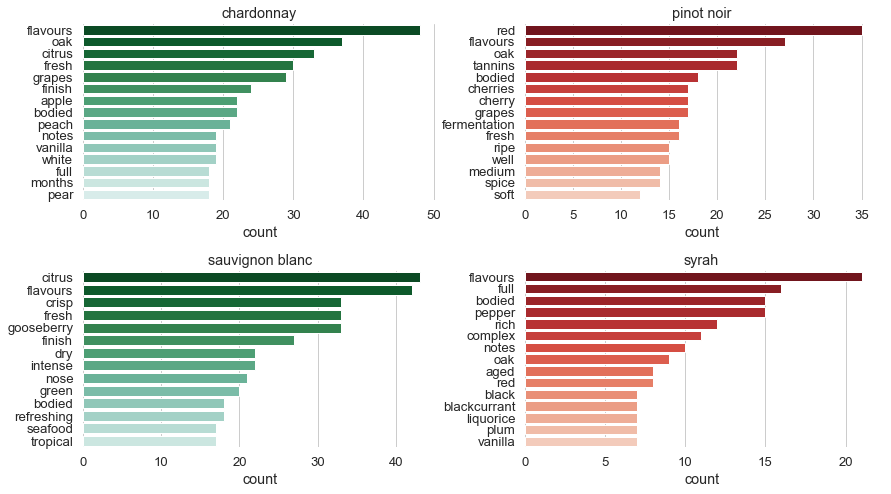

In [11]:
# plot the most frequent words
barplot_wordcounts(df_count, grouped.index, m=2, limit=15)

With these few lines of code we have already obtained some characteristic features of the different grapes. It is quite spectacular. Many of the tastes of wine, like *citrus, apple, gooseberry etc.*, do appear as most frequent words. As you can see many of the words appear in their plural form or ends on *-ed*. We can try to bring them into their basic form and reduce the number of items in the vocabulary. For that we need position tagging and lemmatization.

When sommeliers describing a wine they mostly use nouns and adjectives. These type of words give the most characteristics for the wine. In our next analysis we will filter anything besides nouns and adjectives. 

To perform these steps we define a few helper functions that decide if a word is a noun and create a lemmatizer object as well.

In [12]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc


Above we defined a *LemmaTokenizer* object that will help us to execute several things at once without writing a lot of code. This objects creates a *nltk WordNetLemmatizer* by instantiating it. The *CountVectorizer* object takes it as an argument and calles it. By calling the LemmaTokenizer it will perform the following steps on the input document:

1. defines a pattern that will filter out numbers, words with length smaller than 3 and all kinds of punctuations
2. splits the document into tokens (words)
3. filters out the patterns
4. gets rid of anything that has length = 1 (there can be still one characters because of the previous filtering)
5. performs position tagging
6. selects nouns and adjectives
7. generalizes the type of words into n or a
8. performs lemmatization.

You can have an additional step by uncommenting the last command. It will stem the words. This process is also trying to find common forms of the words.

Actually it is not obligatory to squeez in so many steps into this object, but as you can see, only with one class defined like this we can perform a lot of preprocessing on the document, before actually analysing or classiying the texts. 

Let us see what is the outcome of these steps.

In [13]:
count_vec = CountVectorizer(stop_words=stop_words1, analyzer='word', tokenizer=LemmaTokenizer(),
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [14]:
count_train = count_vec.fit(grouped.loc[:,'description'])
bag_of_words = count_vec.transform(grouped.loc[:,'description'])

Now we instatiate the *CountVectorizer* again with a new argument, called *tokenizer* and apply the *fit* method on it with the text input. Then as before we transform it into a bag-of-words form. Now let us plot again what are the most frequent numbers for the different grape types.

In [15]:
df_count = most_frequent_words(bag_of_words, count_vec, grouped.index)
df_count['rank']=df_count.groupby(['grape'], as_index=False)['count'].rank(ascending=False)

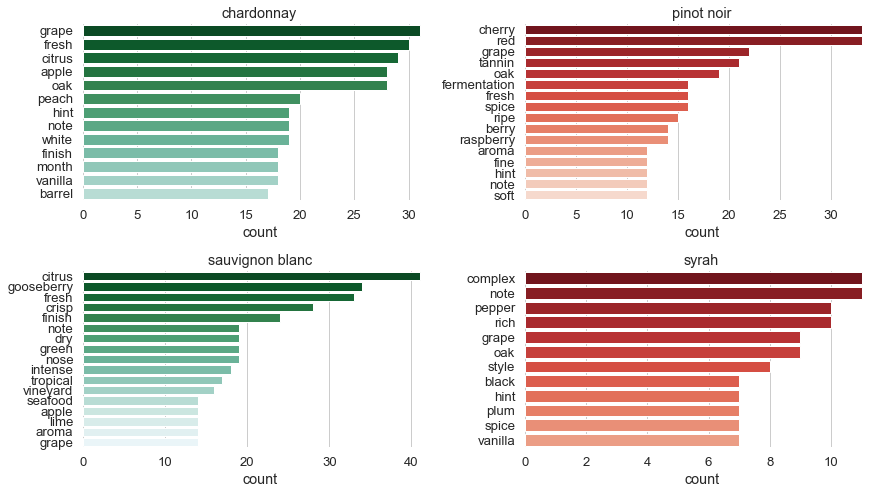

In [16]:
barplot_wordcounts(df_count, grouped.index, m=2, limit=15)

We managed to get rid of most of the plural nouns and increase the raw count of the corresponding singular words (see *cherry-cherries* at pinot noir). Also, there are basically no verbs and adverbs in the plot (the word *bodied* has disappeared from the figure). Besides these observations not much changed compared to the no lemmatizer version.

We can also see that there are several words that are very frequent within and accross the grape types, like *grape, note, etc.* These words are not helping us to distinguish between the grape varieties. Obviously, one could come up with additional noise filters, but in the next section we will present a different approach which tries to measure and weigh the importance of words within and accross documents.

To create a quantitative measure of how well does our *CountVectorizer* differentiate between the grape varieties we calculate the correlation between the vectorized representation of each document.

In [17]:
# transform the bag-of-words matrix into a data frame
a=pd.DataFrame(bag_of_words.toarray(), columns=sorted(count_vec.vocabulary_))
# take its transpose
a=a.T
# rename column names
a.columns=grouped.index

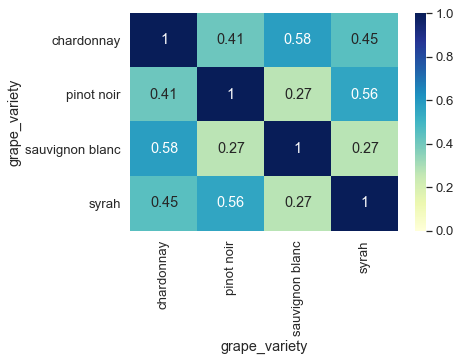

In [18]:
# calculate and plot correlation between grape types
a_count = a[a.columns].corr()
sns.heatmap(a_count, 
            xticklabels=a_count.columns, 
            yticklabels=a_count.columns,
            annot=True, cmap = 'YlGnBu', vmin=0, vmax=1)

We get mostly medium high correlation except between sauvignon blanc and the red wines. As one would expect the correlation is larger within the same colour than between cross colours. However the cross correlations still look a bit high. This is probably due to the many common words that occur in all (or almost all) grape types. These words could be *note, hint, month etc*. If we do not minimize the importance of these words, we risk the possibility that the classifier misidentifies the grape type based on the description more often than it should. 

We can try to compare this result with the results found in [Become a sommelier](https://diveki.github.io/projects/wine/wine.html) section 5. There we searched for the common words for all grape types and calculated the correlation between them. We got even higher numbers there and in some cases cross colour correlations were the biggest (like between chardonnay and pinot noir). The reason for that as we will see later can be found in the number of vocabulary one uses to calculate the correlation. Here we used every word that is present in all of the documents while there we focused only on the common words. Common words obviosly give rise to correlation because they lack the presence of variety spesific description.

Now let us see what can we do to reduce the importance of the frequent common words.

<a id="ch4"></a>
# 4. Inverse document frequency and the Tf-idf vectorizer


Term frequency combined with inverse document frequency is a concept which says if a term is frequent within a document (like the words *the, is, are etc.*) give it a large weight, but if the very same term is frequent over many documents, then it is not characteristic to one description (to one category), therefore scale down its importance. This scaling factor is the inverse of the number of occurence of a term over several documents, namely inverse document frequency (*idf*). Therefore the matrix elements of the bag-of-words model will be $tf \times idf$ for each word. There are several modified forms of this expression, see [[1](#ch7)].

Scikit-learn uses [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) in python to achieve the above objective. The usage of this class is basically the same as the *CountVectorizer*'s. The default setup of this classifier performs normalization of the vectors too. One can choose the type of normalization. 

Relying basically on the very same code as for the *CountVectorizer* we can calculate and visualize the most important words for each grape variety.

In [19]:
tfid_vec = TfidfVectorizer(stop_words=stop_words1, analyzer='word', tokenizer=LemmaTokenizer(),
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [20]:
tfidf_train = tfid_vec.fit(grouped.loc[:,'description'])
bag_of_words = tfid_vec.transform(grouped.loc[:,'description'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [21]:
df_tfidf = most_frequent_words(bag_of_words, tfid_vec, grouped.index)
df_tfidf['rank']=df_tfidf.groupby(['grape'], as_index=False)['count'].rank(ascending=False)
df_tfidf.head()

,grape,token,count,rank
0,chardonnay,/mechanical,0.013083,369.5
1,chardonnay,ability,0.010315,530.0
2,chardonnay,able,0.000000,986.5
3,chardonnay,abundance,0.041258,72.5
4,chardonnay,acacia,0.020629,190.0


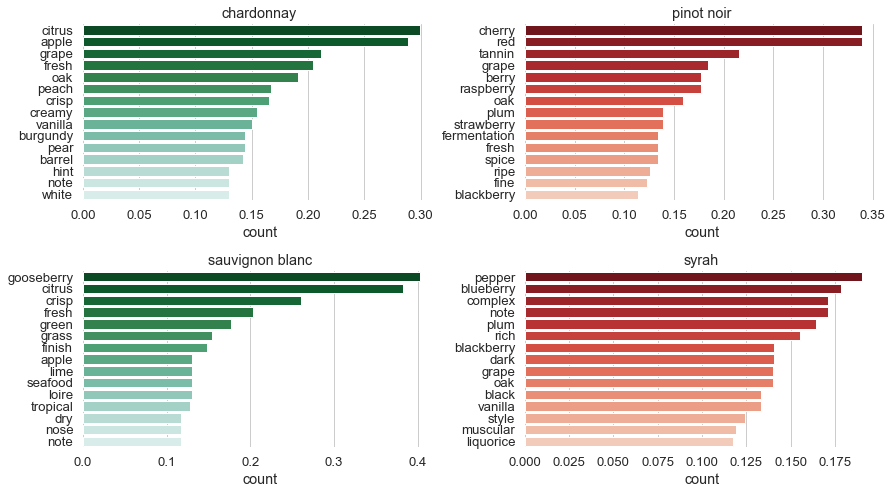

In [22]:
barplot_wordcounts(df_tfidf, grouped.index, m=2, limit=15)

Comparing this result with the one from the end of section 3 we find interesting observations. Only a few new words have appeared in the most important places, the rest got just reshuffled. Here, the words with describing taste and flavour are more emphasized than before. Basically, the words that are very characteristic to the given grape type got favoured and the filling and less descriptive words got pushed back. Go and compare the descriptions of these grape types given by Jancis Robinson (MW) with the characteristics given here [[2-6](#ch7)]. The first word above in the barchart is basically almost the first word in Robinson's descriptions. It is amazing how easily can the tf-idf technique point out important words for a category.

This highlights that we have a better chance to predict the type of the grape of a wine using the TfidfVectorizer than the CountVectorizer. That is what we will do in the [following study](https://diveki.github.io/projects/wine/sommelier.html).

Before going forward let us understand a bit what is actually the *idf* doing. First, we convert our vocabulary with the corresponding *idf* factors into a data frame.

In [23]:
word_idf = pd.DataFrame(
    {
        'token': list(sorted(tfid_vec.vocabulary_)), 
        'idf': tfid_vec.idf_}
)
word_idf.head()

,token,idf
0,/mechanical,1.916291
1,ability,1.510826
2,able,1.916291
3,abundance,1.510826
4,acacia,1.510826


The vocabulary is stored in the *vocabulary_* parameter of the classifier, while the idfs are in the *idf_* parameter. By taking the unique values of the *idf* we will see there are only 4 of them.

In [24]:
idfs = pd.unique(word_idf['idf'].values)
idfs

array([1.91629073, 1.51082562, 1.22314355, 1.        ])

According to the description on the scikit-learn website these numbers are calculated with the following expression: $idf(t)=\log(\frac{1+n_d}{1+df(d,t)}) + 1$, where $t$ is a term, $n_d$ is the number of different documents (in our case it is 4), and $df(d,t)$ is the number of documents that contain term $t$ (in our case it can range from 1 to 4). 

It is easy to see that $idf(t)=1$ corresponds to the case when each document contains that term. Those words are down scaled beacause it is thought that they do not contribute to the identification of the documents topic. When $idf(t)\approx 1.92$, only one document mentions the given term. 

Let us now see, how many words are contained in 1, 2, 3 or 4 documents in our case.

In [30]:
print('Ratio of words contained in 1 document: %.3f pct' % (word_idf[word_idf['idf']==idfs[0]].shape[0]/word_idf.shape[0]*100)) # number of words contained in 1 document
print('Ratio of words contained in 2 documents: %.3f pct' % (word_idf[word_idf['idf']==idfs[1]].shape[0]/word_idf.shape[0]*100)) # number of words contained in 2 documents
print('Ratio of words contained in 3 documents: %.3f pct' % (word_idf[word_idf['idf']==idfs[2]].shape[0]/word_idf.shape[0]*100)) # number of words contained in 3 documents
print('Ratio of words contained in 4 documents: %.3f pct' % (word_idf[word_idf['idf']==idfs[3]].shape[0]/word_idf.shape[0]*100)) # number of words contained in 4 documents

Ratio of words contained in 1 document: 66.122 pct
Ratio of words contained in 2 documents: 19.168 pct
Ratio of words contained in 3 documents: 9.212 pct
Ratio of words contained in 4 documents: 5.498 pct


Apparently, about one third of the words are mentioned only in one document while about 5% of them are common to every document. It is interesting to see that many of the most important words in the above graph can be found in all or several documents. This means that quite a few most important words are coming from less than 6% of the vocabulary. Moreover, from the 67% of that come from only one document, not many are making into the most important ones. 

Let us again compare the correlation between different grapes using this tf-idf corrected results.

In [31]:
a=pd.DataFrame(bag_of_words.toarray(), columns=sorted(tfid_vec.vocabulary_))
a=a.T
a.columns=grouped.index
atfidf = a.corr()

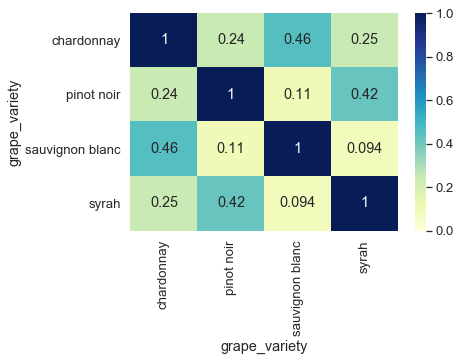

In [32]:
sns.heatmap(atfidf, 
        xticklabels=atfidf.columns,
        yticklabels=atfidf.columns,
           annot=True, cmap = 'YlGnBu', vmin=0, vmax=1)

Interestingly the correlations had lowered in general. This is good news, since 0 correlation (or no correlation) would mean that there is a big chance to differenciate these grape varieties without labelling one of them to the other. The same colour wines are still more correlated to each other than the different colours. 

This finding assures us that *TfidfVectorizer* could be a good choice to vectorize our text. We will use this method combined with a classifier to predict the grape type of unseen wine descriptions. 

Next we select the words that are common to all 4 documents and take their correlation. By doing this we get closer to the results presented in the [previous study](https://diveki.github.io/projects/wine/wine.html) section 5, common words. 

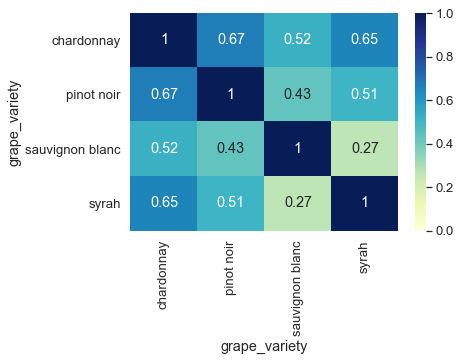

In [33]:
# common words to all of them
acommon = a[a.index.isin(list(word_idf[word_idf['idf']==idfs[3]]['token']))].corr()
sns.heatmap(acommon, 
        xticklabels=acommon.columns,
        yticklabels=acommon.columns,
           annot=True, cmap = 'YlGnBu', vmin=0, vmax=1)

We do not get exactly the same numbers because we use *TfidfVectorizer* here instead of the *CountVectorizer*. Nevertheless, the results are quite close to each other. This is an other example that using only a portion of the vocabulary is not enough to separate the grape types. Also a good example that relying on scikit-learn's objects are leading to less code and faster results. 

In the next section, we apply the above learned knowledge to one grape variety and analyse how correlated the descriptions are to each other.

<a id="ch5"></a>
# 5. Similarity study of documents belonging to one class


We choose the red wine grape syrah as an example to work with in the following

In [56]:
syrah = X_train[X_train.grape_variety == 'syrah']
syrah.head()

,description,grape_variety
210,are dedicated to showcasing the wide range of ...,syrah
69,this medium-bodied cote rotie is surprisingly ...,syrah
76,the explorateur wine offers sweet aromas of bl...,syrah
215,translates as lion 's den and is named after t...,syrah
234,full of robust and concentrated blackcurrant f...,syrah


In our database this grape does not have a lot of documents to work with, so it will be easy to visualize the results. We simply apply the procedure learnt in [section 4](#ch4), but instead of having 4 different grape type description as the input, we have several documents belonging to one grape type.

In [57]:
tfidf_train = tfid_vec.fit(syrah.loc[:,'description'])
bag_of_words = tfid_vec.transform(syrah.loc[:,'description'])

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


First we take a look at the size of our vocabulary (the number of terms we are looking at). We also print the number of documents available for the syrah grape.

In [58]:
print(f'Vocabulary size:  {bag_of_words.shape[1]}')
print(f'Number of documents:  {bag_of_words.shape[0]}')

Vocabulary size:  355
Number of documents:  27


From the 27 documents that we preprocessed we have 355 words to work with. In principle these words contain the ones that are characteristic to this grape type. It would be interesting to look at how correlated are these description with each other. Are they really mentioning the same words in the same way in each document?

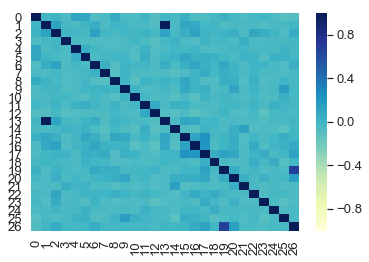

In [59]:
voc = tfid_vec.vocabulary_
asyrah=pd.DataFrame(bag_of_words.toarray(), columns=sorted(voc))
asyrah=asyrah.T
#a.columns=grouped.index
acorr=asyrah.corr()
sns.heatmap(acorr, 
        xticklabels=acorr.columns,
        yticklabels=acorr.columns,
           cmap = 'YlGnBu', vmin=-1, vmax=1)

The range of the heatmap goes from -1 to 1. The diagonal shows the correlation of a document with itself, therefore its value is 1. There are 2 more dots (symmetrically located) that have a value of 1. It means that documents 1 and 13 are identical. This highlights a weakness in our preprocessing. We should not allow duplicated documents. In a supervised classification, duplication may put more weight on certain features (words). Documents 26 and 19 have a high correlation value too (but not equal to 1). These two might share a lot of common words. Let us look at them.

In [62]:
syrah.reset_index().loc[19,'description']

'flavours of graphite, strawberry compote, and lilacs. the nose is incredibly complex, with notes of forest fruits and mint. this wine is from the rhone region in france and is made from the wine grape variety (also known as wine). wine usually has aromas of peppery spice and this wine certainly does. it is a full-bodied wine with smoky aromas and flavours of blackberries. aged in vat.'

In [61]:
syrah.reset_index().loc[26,'description']

'this rich wine has flavours of strawberry compote, lilacs, and red berries. this wine is from the rhone region in france and is made from the wine grape variety (also known as wine). wine usually has aromas of peppery spice and this wine certainly does. it is a full-bodied wine with smoky aromas and flavours of blackberries. the wine is aged in vats before bottling.'

It turns out that their description is almost identical. There are only a few differences. That explains why is the correlation so high.

The rest of the correlations are quite low, close to 0. This is good news. It means that the descriptions of each documents are not much similar to each other, they are constructed in different ways probably using many different words too. Still, when putting these descriptions into one basket they form a language very characteristic to that grape type. 

<a id="ch6"></a>
# 6. Conclusion
In this report we presented classes and methods to perform text analysis to derive characteristic features of grape varieties from semi-professional wine descriptions. 

We relied on the bag-of-word concept in transforming a text into mathematically comprehensible form. To do this we used the *CountVectorizer* and *TfidfVectorizer* classes to create vector of words. We showed that the latter has more potential to highlight class specific words and features. 

By calculating the correlation between the vectorized categories we could conclude that the developed process, although being simple, is quite good at decorrelating the categories based on the descriptions. These findings help to understand the background of the decisions made by a grape variety forecaster. Such kind of forecaster will be presented in the [next report](https://diveki.github.io/projects/wine/sommelier.html). 

Since this analysis is based on a simplistic approach there is plenty of rooms for improvement:
- Collecting much more data and preferably less noisy data from professional wine experts.
- Write better noise filters that may remove words that do not contain important information about the grape.
- Improve POS tagging to find the right tags .
- Improve lemmatization, since there were many words not identified as the same token while having slightly different forms.
- One could apply stemming too.
- Write a complex code for information extraction into categories like taste, aroma, flavor, palatte, body etc. Finding words into these predefind categories could boost the performance of an algorithmic sommelier by a lot. 

Finally we showed that **using methodical analysis, algorithms can help people to become excellent sommeliers.**

If you have any questions, observations or suggestions please contact me at [diveki@gmail.com](diveki@gmail.com). You can also fork this project from [my GitHub repository](https://github.com/diveki/WineSommelier) or you can take a sneaky look at [my GitHub Pages website](https://diveki.github.io). 



<a id="ch7"></a>
# 7. References
1. https://en.wikipedia.org/wiki/Tf%E2%80%93idf
2. https://www.jancisrobinson.com/learn/grape-varieties/white/sauvignon-blanc
3. https://www.jancisrobinson.com/learn/grape-varieties/white/chardonnay
4. https://www.jancisrobinson.com/learn/grape-varieties/red/pinot-noir
5. https://www.jancisrobinson.com/learn/grape-varieties/red/shiraz
6. https://www.jancisrobinson.com/learn/grape-varieties/red/syrah